In [1]:
import pathlib

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [3]:
n_particles = 1_000

r = torch.rand((2,n_particles)).to(device)
v = torch.rand((2,n_particles)).to(device)
m = torch.ones((n_particles, )).to(device)
m[0] = 10
m[1] = 10

In [4]:
ids = torch.arange(n_particles)

In [5]:
ids_pairs = torch.combinations(ids,2).to(device)

In [6]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff, k: float = 50):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    fs = torch.zeros((ts, r.shape[0])).to(device)
    
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        
        v *= m
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        v /= m
        
        dr = r[:, 0] - r[:, 1]
        f = k * dr
        v[:, 0] -= f * dt
        v[:, 1] += f * dt
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
        fs[i] = f
        
    return rs, vs, fs

In [7]:
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

v[0][ixr] = -500
v[0][ixl] = 500

In [8]:
radius = 0.005
rs, vs, fs = motion(r, v, ids_pairs, ts=10_000, dt=0.000008, d_cutoff=2*radius, k=500_000)

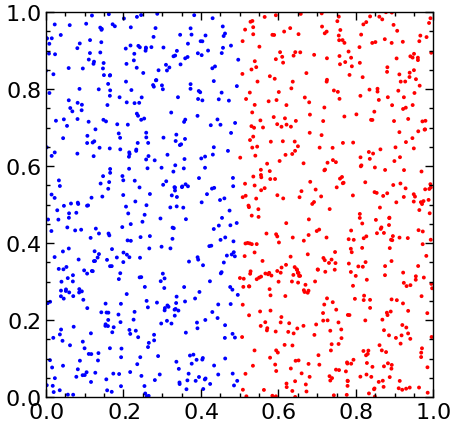

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

In [10]:
# fig, ax = plt.subplots(1,1,figsize=(5,5))
# ax.clear()
# vmin = 0
# vmax = 1
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
# 
# spring, = ax.plot([], [], 'o', color='black', markersize=10*markersize)
# red, = ax.plot([], [], 'o', color='red', markersize=markersize)
# blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)
# 
# def animate(i):
#     print(f"{i=}")
#     xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
#     xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
#     x_spring, y_spring = rs[i][0][0:2].cpu(), rs[i][1][0:2].cpu()
#     red.set_data(xred, yred)
#     blue.set_data(xblue, yblue)
#     spring.set_data(x_spring, y_spring)
#     return red, blue
# 
# # writer = animation.FFMpegWriter(fps=30)
# ani = animation.FuncAnimation(fig, animate, frames=1_000, interval=25, blit=True)
# path = pathlib.Path('./anim_brown_spring.gif')
# ani.save(path, dpi=100)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].clear()
ax[1].clear()
vmin = 0
vmax = 1

# x_lim = (torch.min(rs[:, 0, :]).cpu() - 1, torch.max(rs[:, 0, :]).cpu() + 1)
# y_lim = (torch.min(rs[:, 1, :]).cpu() - 1, torch.max(rs[:, 1, :]).cpu() + 1)

x_lim, y_lim = (0, 1), (0, 1)

markersize = 2 * radius * ax[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
spring, = ax[0].plot([], [], 'o', color='black', markersize=10*markersize)
red, = ax[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = ax[0].plot([], [], 'o', color='blue', markersize=markersize)
force, = ax[1].plot([], [], color='k')

def animate(i):
    print(f"{i=}")
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    x_spring, y_spring = rs[i][0][0:2].cpu(), rs[i][1][0:2].cpu()
    # red.set_data(xred, yred)
    # blue.set_data(xblue, yblue)
    # force.set_data(np.arange(1_000)[0:i], fs.norm(dim=1).cpu()[0:i])
    # return [(red, blue), force]

    ax[0].clear()
    ax[1].clear()

    ax[0].scatter(xred, yred, color='red')
    ax[0].scatter(xblue, yblue, color='blue')
    ax[0].scatter(x_spring, y_spring, color='black', s=5*(plt.rcParams['lines.markersize'] ** 2))
    ax[1].plot(np.arange(10_000)[0:i], fs.norm(dim=1).cpu()[0:i])

    ax[0].set_xlim(x_lim)
    ax[0].set_ylim(y_lim)

# writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=5_000, interval=25, blit=False)
path = pathlib.Path('./anim_brown_spring.gif')
ani.save(path, dpi=100)

MovieWriter ffmpeg unavailable; using Pillow instead.


i=0
i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49
i=50
i=51
i=52
i=53
i=54
i=55
i=56
i=57
i=58
i=59
i=60
i=61
i=62
i=63
i=64
i=65
i=66
i=67
i=68
i=69
i=70
i=71
i=72
i=73
i=74
i=75
i=76
i=77
i=78
i=79
i=80
i=81
i=82
i=83
i=84
i=85
i=86
i=87
i=88
i=89
i=90
i=91
i=92
i=93
i=94
i=95
i=96
i=97
i=98
i=99
i=100
i=101
i=102
i=103
i=104
i=105
i=106
i=107
i=108
i=109
i=110
i=111
i=112
i=113
i=114
i=115
i=116
i=117
i=118
i=119
i=120
i=121
i=122
i=123
i=124
i=125
i=126
i=127
i=128
i=129
i=130
i=131
i=132
i=133
i=134
i=135
i=136
i=137
i=138
i=139
i=140
i=141
i=142
i=143
i=144
i=145
i=146
i=147
i=148
i=149
i=150
i=151
i=152
i=153
i=154
i=155
i=156
i=157
i=158
i=159
i=160
i=161
i=162
i=163
i=164
i=165
i=166
i=167
i=168
i=169
i=170
i=171
i=172
i=173
i=174
i=175
i=176
i=177
i=178
i=179
i=180
i=181
i=182
i=183
i=

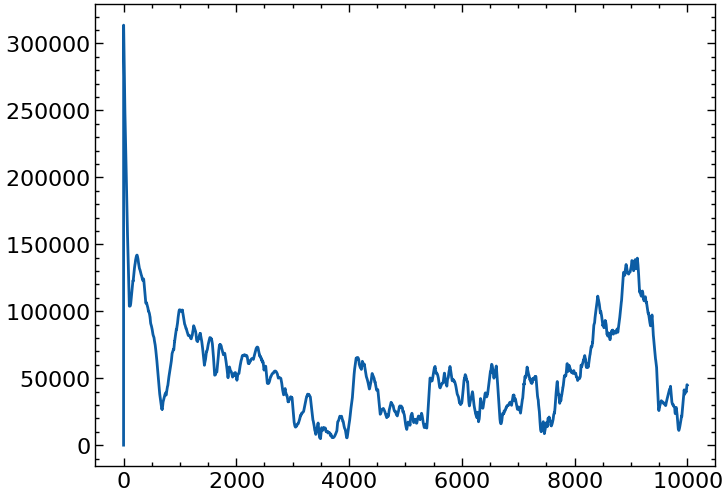

In [17]:
plt.plot(np.arange(10_000), fs.norm(dim=1).cpu())

In [18]:
plt.rcParams['lines.markersize'] ** 2

36.0

In [19]:
from scipy import fft

In [20]:
force = fs.norm(dim=1).cpu().numpy()
force_fft = fft.fft(force)

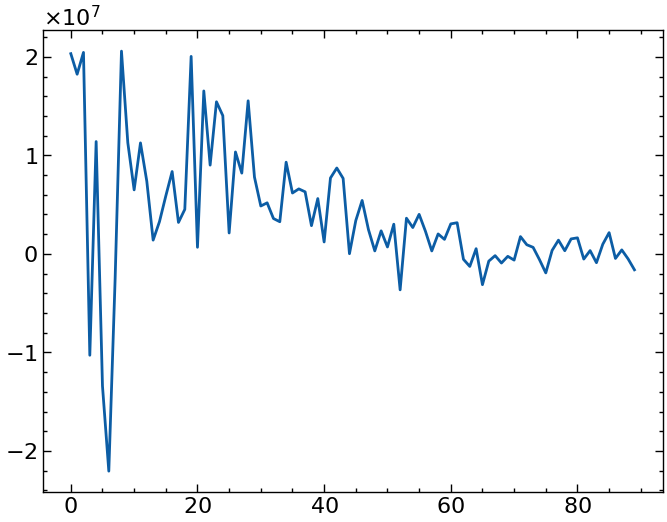

In [21]:
plt.plot(force_fft[10:100])